## TP2 - Paul Rongieras

In [1]:
## Standard libraries
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## PyTorch
import torch

## Torchvision
import torchvision
from torchvision.datasets import SVHN, MNIST, USPS
import torchvision.transforms as T
from torch.utils.data import DataLoader

## Sklearn
from sklearn.manifold import TSNE

## UMAP
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  print("Using Google Colab")
  !pip install umap-learn
  from umap import UMAP
else:
  from umap import UMAP

# Path to the folder where the datasets are/should be downloaded
DATASET_PATH = "./data"

Using Google Colab


In [2]:
print("Using torch", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print ("MPS (MacBook) device found.")
    #print('Number of MPS cards: ', torch.mps.device_count())
    #print('Total MPS memory {0:.2f} GB'.format(torch.mps.recommended_max_memory()/pow(10,9)))
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    # Ensure that all operations are deterministic on GPU (if used) for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print ("CUDA device found.")
    print('Number of GPU cards: ', torch.cuda.device_count(), '\nWhich card GPU?', torch.cuda.get_device_name(0))
    print('Total GPU memory {1:.2f} GB. Free GPU memory {0:.2f} GB'.format(torch.cuda.mem_get_info()[0]/pow(10,9),torch.cuda.mem_get_info()[1]/pow(10,9)))
else:
   device = torch.device("cpu")
   print('No MPS or CUDA has been found. PyTorch will use CPU.')

Using torch 2.9.0+cu126
CUDA device found.
Number of GPU cards:  1 
Which card GPU? Tesla T4
Total GPU memory 15.83 GB. Free GPU memory 15.72 GB


In this practical session you will implement and test the method presented in [1] for Unsupervised Domain Adaptation.

You will use three imaging datasets showing 0-9 digits: MNIST, SVHN and USPS.

We know that the output spaces are equal (same labels/classes), namely the digits from 0 to 9, and we will resize the data so that the input spaces are also equal (same number of pixels per image).

In this TP, you will assume a covariate shift and therefore that there is a shift between the marginal disitributions $p_S(X)$ and $p_T(X)$ and that the conditional distributions $p_S(Y|X)$ and $p_t(Y|X)$ are equal.

As for the other TP, answer all questions and fill the code where you see **XXXXXXXXX**

**Deadline**: please verify on the Moodle/Ecampus the deadline



[1] B. Fernando et al. “Unsupervised Visual Domain Adaptation Using Subspace Alignment”. In: ICCV. 2013.

### **MNIST**

 Let's start by downloading the **MNIST** dataset: a very common and large database of grayscale images showing handwritten digits ranging from 0 to 9. It comprises 60,000 training images and 10,000 testing images of size 28x28.

To cope with the assumption about the "same number of input pixels per image", we choose the input dimension of 32x32 for all datasets. We thus resize all images (originally 28x28) using the padding function "Pad" (add 0 to the borders).


In [3]:
# Transform to normalized Tensors in the range [0,1]
MNIST_train_dataset = MNIST(root=DATASET_PATH, train= True, download=True, transform=T.Compose([T.Pad(2), T.ToTensor()]))
MNIST_test_dataset = MNIST(root=DATASET_PATH, train= False, download=True, transform=T.Compose([T.Pad(2), T.ToTensor()]))

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.65MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.72MB/s]


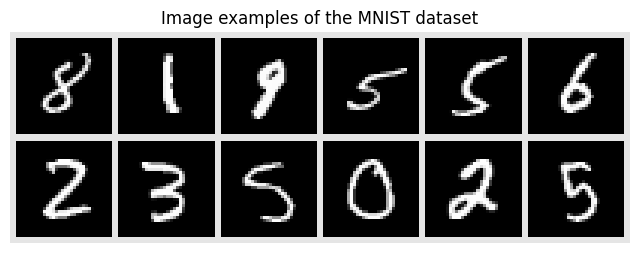

In [4]:
# Visualize some examples
NUM_IMAGES = 12
MNIST_images = torch.stack([MNIST_train_dataset[np.random.randint(len(MNIST_train_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(MNIST_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

Be careful ! Even if you put a transform when downloading the data and creating teh Pytorch Dataset, this is actually not applied until you load the data with a DataLoader.

For instance, when you load images in the range $[0,255]$ and you put the transform `ToTensor()`, this should automatically normalize the images in the range $[0,1]$ and transform them into Pytorch tensors. However, if you simply take the data from the DataSet *WITHOUT* the DataLoader...

In [5]:
#This does not apply the normalization to [0-1] (transform To.Tensor() )
MNIST_Xtrain_255 = MNIST_train_dataset.data.numpy()
MNIST_ytrain_255 = MNIST_train_dataset.targets.numpy()


In [6]:
print(MNIST_Xtrain_255.shape)
print(MNIST_ytrain_255.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtrain_255.min(), MNIST_Xtrain_255.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(MNIST_Xtrain_255.mean(), MNIST_Xtrain_255.std()))
print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtrain_255.min(), MNIST_Xtrain_255.max()))

(60000, 28, 28)
(60000,)
Min Pixel Value: 0 
Max Pixel Value: 255
Mean Pixel Value 33.318421449829934 
Pixel Values Std: 78.56748998339798
Min Pixel Value: 0 
Max Pixel Value: 255


Instead, if we load them with the Dataloader...

In [7]:
MNIST_train_loader = DataLoader(MNIST_train_dataset, batch_size=len(MNIST_train_dataset))
MNIST_test_loader = DataLoader(MNIST_test_dataset, batch_size=len(MNIST_test_dataset))

MNIST_Xtrain_ima = np.squeeze(next(iter(MNIST_train_loader))[0].numpy())
MNIST_ytrain = next(iter(MNIST_train_loader))[1].numpy()

MNIST_Xtest_ima = np.squeeze(next(iter(MNIST_test_loader))[0].numpy())
MNIST_ytest = next(iter(MNIST_test_loader))[1].numpy()


In [8]:
print(MNIST_Xtrain_ima.shape)
print(MNIST_ytrain.shape)

print(MNIST_Xtest_ima.shape)
print(MNIST_ytest.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtrain_ima.min(), MNIST_Xtrain_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(MNIST_Xtrain_ima.mean(), MNIST_Xtrain_ima.std()))

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtest_ima.min(), MNIST_Xtest_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(MNIST_Xtest_ima.mean(), MNIST_Xtest_ima.std()))

(60000, 32, 32)
(60000,)
(10000, 32, 32)
(10000,)
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.10003671795129776 
Pixel Values Std: 0.2752174437046051
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.10145653039216995 
Pixel Values Std: 0.2774091958999634


(12, 32, 32)


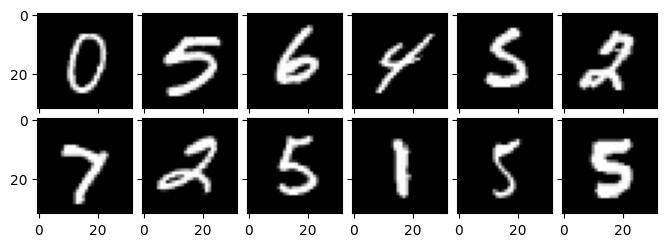

In [9]:
from mpl_toolkits.axes_grid1 import ImageGrid

NUM_IMAGES=12
MNIST_grid = MNIST_Xtrain_ima[np.random.randint(0,len(MNIST_Xtrain_ima),12),:,:]
print(MNIST_grid.shape)

fig = plt.figure(figsize=(8,8))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 6),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, MNIST_grid):
    # Iterating over the grid returns the Axes.
    ax.imshow(im,cmap='gray')

plt.show()

So we have 60k training images and 10K test images of size $[32 x 32]$. Let's load another dataset

### **SVHN dataset**

The Street View House Numbers (SVHN) dataset is a real-world image dataset for house number detection. It is similar to MNIST since it has the same digit classes (0 to 9), but it is significantly harder due to its real-world setting. SVHN is obtained from house numbers in Google Street View images.

It comprises RGB images of size $32x32$

We change them from RGB to grayscale to compare them with the MNIST images.


In [10]:
SVHN_train_dataset = SVHN(root=DATASET_PATH, split='train', download=True, transform=T.Compose([T.Grayscale(), T.ToTensor()]))
SVHN_test_dataset = SVHN(root=DATASET_PATH, split='test', download=True, transform=T.Compose([T.Grayscale(), T.ToTensor()]))

100%|██████████| 182M/182M [00:14<00:00, 12.5MB/s]
100%|██████████| 64.3M/64.3M [00:01<00:00, 34.8MB/s]


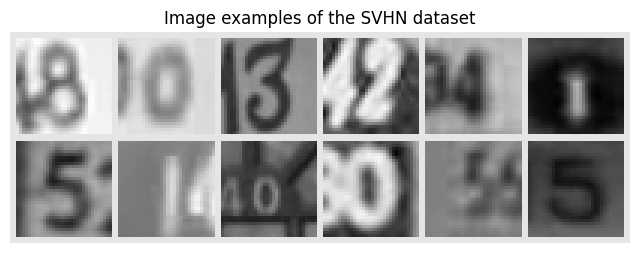

In [11]:
# Visualize some examples
NUM_IMAGES = 12
SVHN_images = torch.stack([SVHN_test_dataset[np.random.randint(len(SVHN_test_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(SVHN_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the SVHN dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [12]:
SVHN_train_loader = DataLoader(SVHN_train_dataset, batch_size=len(SVHN_train_dataset))
SVHN_test_loader = DataLoader(SVHN_test_dataset, batch_size=len(SVHN_test_dataset))

SVHN_Xtrain_ima = np.squeeze(next(iter(SVHN_train_loader))[0].numpy())
SVHN_ytrain = next(iter(SVHN_train_loader))[1].numpy()

SVHN_Xtest_ima = np.squeeze(next(iter(SVHN_test_loader))[0].numpy())
SVHN_ytest = next(iter(SVHN_test_loader))[1].numpy()


In [13]:
print(SVHN_Xtrain_ima.shape)
print(SVHN_ytrain.shape)
print(SVHN_Xtest_ima.shape)
print(SVHN_ytest.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(SVHN_Xtrain_ima.min(), SVHN_Xtrain_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(SVHN_Xtrain_ima.mean(), SVHN_Xtrain_ima.std()))

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(SVHN_Xtest_ima.min(), SVHN_Xtest_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(SVHN_Xtest_ima.mean(), SVHN_Xtest_ima.std()))

(73257, 32, 32)
(73257,)
(26032, 32, 32)
(26032,)
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.4452594220638275 
Pixel Values Std: 0.196975976228714
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.45435550808906555 
Pixel Values Std: 0.2220025360584259


Here we have ~73K training images and ~26K test images of the same size $[32 x x32]$

### **USPS**

As last dataset, we will use the USPS dataset which contains images of digits (from 0 to 9) scanned from envelopes by the U.S. Postal Service. It contains a total of 9,298 $16x16$ pixel grayscale images. Images are centered, normalized and show a broad range of font styles.

Even in ths case, we pad them with 0 in order to have $32 x 32$ images.

In [14]:
USPS_train_dataset = USPS(root=DATASET_PATH, train= True, download=True, transform=T.Compose([T.Pad(8), T.ToTensor()]))
USPS_test_dataset = USPS(root=DATASET_PATH, train= False, download=True, transform=T.Compose([T.Pad(8), T.ToTensor()]))

100%|██████████| 6.58M/6.58M [00:01<00:00, 4.18MB/s]
100%|██████████| 1.83M/1.83M [00:00<00:00, 2.17MB/s]


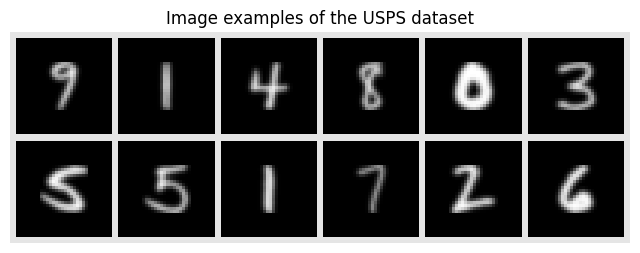

In [15]:
# Visualize some examples
NUM_IMAGES = 12
USPS_images = torch.stack([USPS_train_dataset[np.random.randint(len(USPS_train_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(USPS_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the USPS dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [16]:
USPS_train_loader = DataLoader(USPS_train_dataset, batch_size=len(USPS_train_dataset))
USPS_test_loader = DataLoader(USPS_test_dataset, batch_size=len(USPS_test_dataset))

USPS_Xtrain_ima = np.squeeze(next(iter(USPS_train_loader))[0].numpy())
USPS_ytrain = next(iter(USPS_train_loader))[1].numpy()

USPS_Xtest_ima = np.squeeze(next(iter(USPS_test_loader))[0].numpy())
USPS_ytest = next(iter(USPS_test_loader))[1].numpy()

In [17]:
print(USPS_Xtrain_ima.shape)
print(USPS_ytrain.shape)
print(USPS_Xtest_ima.shape)
print(USPS_ytest.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(USPS_Xtrain_ima.min(), USPS_Xtrain_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(USPS_Xtrain_ima.mean(), USPS_Xtrain_ima.std()))

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(USPS_Xtest_ima.min(), USPS_Xtest_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(USPS_Xtest_ima.mean(), USPS_Xtest_ima.std()))

(7291, 32, 32)
(7291,)
(2007, 32, 32)
(2007,)
Min Pixel Value: 0.0 
Max Pixel Value: 0.9960784316062927
Mean Pixel Value 0.06171923503279686 
Pixel Values Std: 0.18373751640319824
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.06497029960155487 
Pixel Values Std: 0.19083774089813232


We have ~7K training images and ~2k test images of size $[32 x 32]$

### **UMAP**

One of the first things to do, is to visually check the data to verify if it exists a domain gap and if the datasets are different.

Here, we will use the UMAP and t-SNE methods which are general manifold learning and non-linear dimension reduction algorithms (probably the two most-used ones). UMAP can be seen as a Riemannian extension of the t-SNE method (which uses an Euclidean distance).

[1] Leland McInnes, John Healy, James Melville. "UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction". 2018

[2] van der Maaten, L.J.P., Hinton, G.E. "Visualizing Data Using t-SNE". Journal of Machine Learning Research. 2008


Transform data so that instead than having 3D arrays of images we will have 2D arrays by vectorizing each image -> 32 x 32 = 1024

In [24]:
# MNIST
MNIST_Xtrain=np.reshape(MNIST_Xtrain_ima, (-1,1024))
MNIST_Xtest=np.reshape(MNIST_Xtest_ima, (-1,1024))

print(MNIST_Xtrain.shape, MNIST_Xtest.shape)

# USPS
USPS_Xtrain=np.reshape(USPS_Xtrain_ima,(-1,1024))
USPS_Xtest=np.reshape(USPS_Xtest_ima,(-1,1024))

print(USPS_Xtrain.shape, USPS_Xtest.shape)

# SVHN
SVHN_Xtrain=np.reshape(SVHN_Xtrain_ima,(-1,1024))
SVHN_Xtest=np.reshape(SVHN_Xtest_ima,(-1,1024))

print(SVHN_Xtrain.shape, SVHN_Xtest.shape)

(60000, 1024) (10000, 1024)
(7291, 1024) (2007, 1024)
(73257, 1024) (26032, 1024)


Here, we randomly pick only 1000 samples per dataset for visualization and to reduce the computational burden.

In [31]:
# Reduced MNIST
indices_mnist = np.random.choice(MNIST_ytrain.shape[0], 1000, replace = False)
MNIST_Xtrain_res = MNIST_Xtrain[indices_mnist]
MNIST_ytrain_res = MNIST_ytrain[indices_mnist]

# Reduced USPS
indices_usps = np.random.choice(USPS_ytrain.shape[0], 1000, replace = False)
USPS_Xtrain_res = USPS_Xtrain[indices_usps]
USPS_ytrain_res = USPS_ytrain[indices_usps]

# Reduced SVHN
indices_svhn = np.random.choice(SVHN_ytrain.shape[0], 1000, replace = False)
SVHN_Xtrain_res = SVHN_Xtrain[indices_svhn]
SVHN_ytrain_res = SVHN_ytrain[indices_svhn]


# Reduced Data
xtot=np.concatenate((MNIST_Xtrain_res,USPS_Xtrain_res,SVHN_Xtrain_res),axis=0) # all data
nMNIST=MNIST_Xtrain_res.shape[0]
nUSPS=USPS_Xtrain_res.shape[0]
nSVHN=SVHN_Xtrain_res.shape[0]

In [32]:
xp = UMAP().fit_transform(xtot) # this should take ~50sec

print(xp.shape)

# separate again but now in 2D
xpMNIST=xp[:nMNIST,:]
xpUSPS=xp[nMNIST:nMNIST+nUSPS,:]
xpSVHN=xp[nMNIST+nUSPS:,:]

(3000, 2)


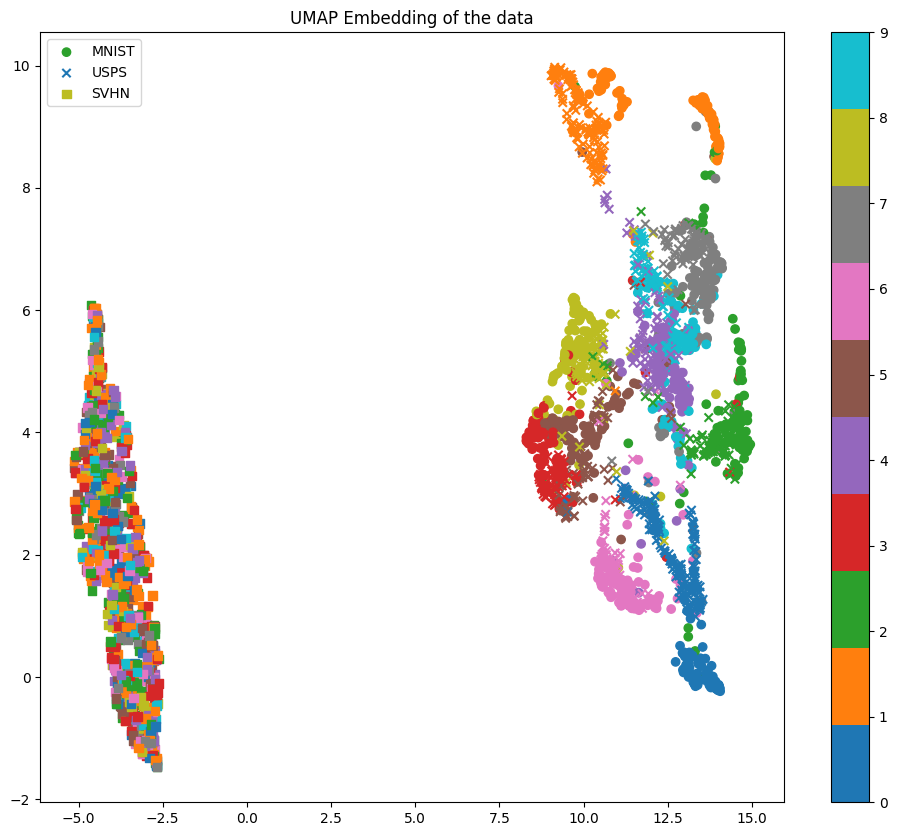

In [33]:
plt.figure(3,(12,10))

plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
plt.scatter(xpSVHN[:,0],xpSVHN[:,1],c=SVHN_ytrain_res,marker='s',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the data')
plt.show()

It seems that one dataset is quite different from the other two.

**Question**: What are your conclusions ? Re-run the code showing only the most similar datasets.

Our predictions are confirmed, the 2 datasets that are really close visually are also close after the UMAP embdedding, while the third one (SVHN) is really far. This is because of a domain gap/domain shift, and more precisely a covariate shift: labels and conditional distributionals are the same, but marginals are different.

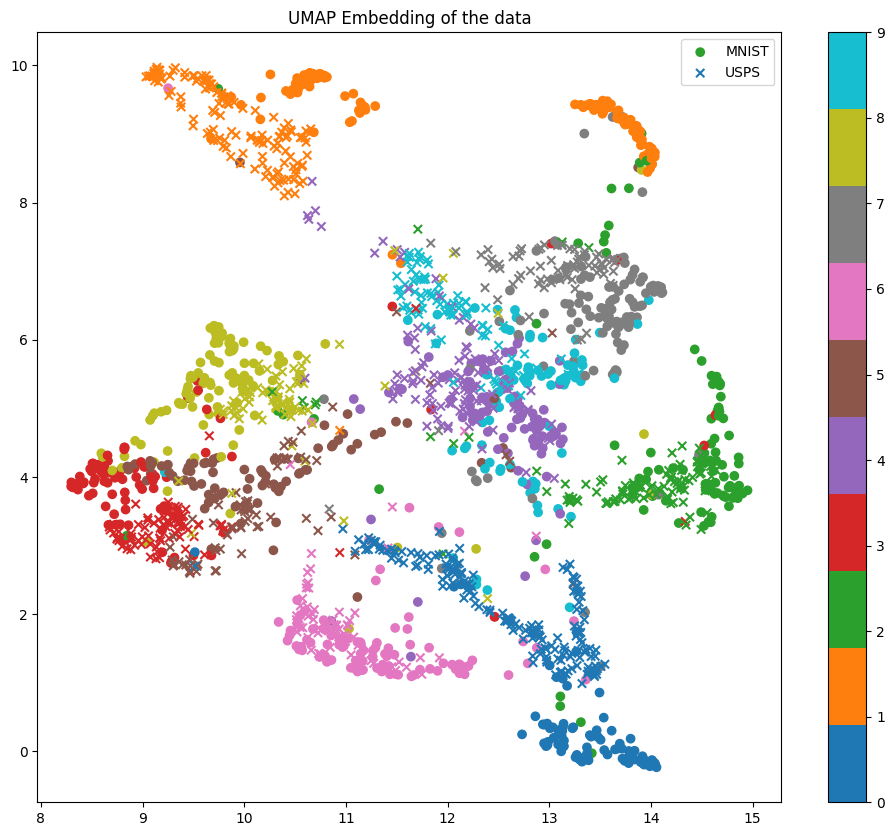

In [34]:
plt.figure(3,(12,10))

plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the data')
plt.show()

**Question**: Can you see a domain shift between the datasets ?

It appears that there is probably no domain shift between those 2 datasets, as marginals are close to each other.

Now we can test the t-SNE algorithm to check whether your conclusions are confirmed.

In [35]:
%time xp=TSNE().fit_transform(xtot) # this should take around 50 sec

print(xp.shape)

# separate again but now in 2D
xpMNIST=xp[:nMNIST,:]
xpUSPS=xp[nMNIST:nMNIST+nUSPS,:]
xpSVHN=xp[nMNIST+nUSPS:,:]
print(xpMNIST.shape,xpUSPS.shape,xpSVHN.shape)

CPU times: user 31.4 s, sys: 48.8 ms, total: 31.4 s
Wall time: 34.7 s
(3000, 2)
(1000, 2) (1000, 2) (1000, 2)


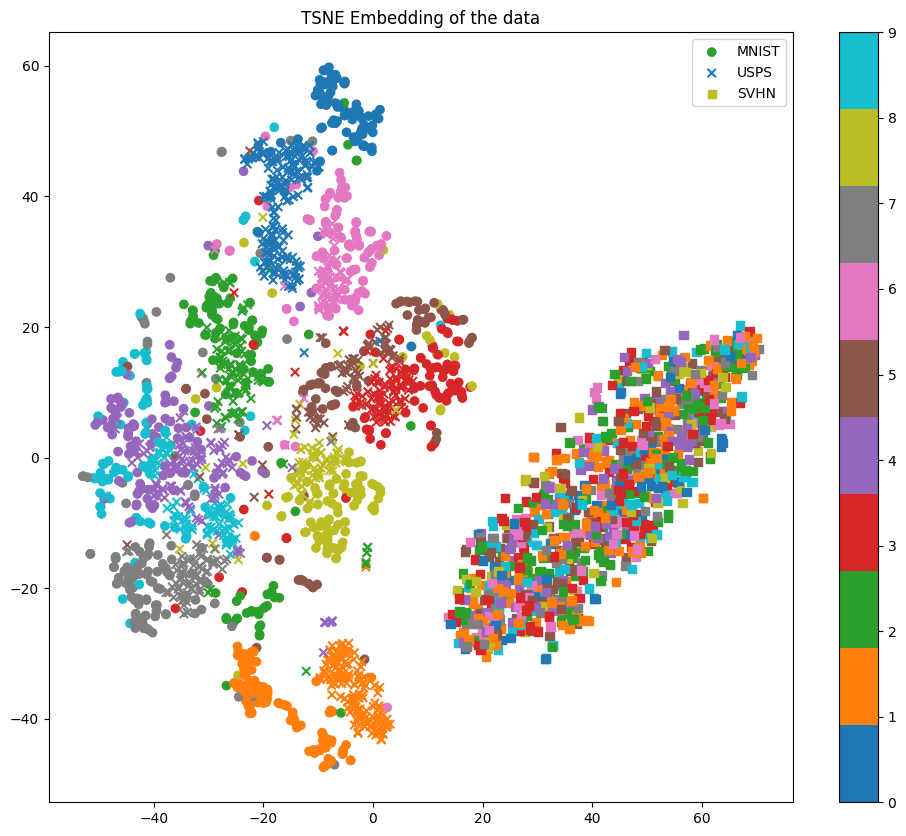

In [36]:
plt.figure(3,(12,10))

plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
plt.scatter(xpSVHN[:,0],xpSVHN[:,1],c=SVHN_ytrain_res,marker='s',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('TSNE Embedding of the data')
plt.show()

**Question**: can you confirm your previous conclusions ?

The t-SNE embedding provides the same conclusion as there is a clear separation between SVHN and the 2 other datasets. Furthermore, for each class, points from USPS and points from MNIST are close enough to assume that there is no domain shift between those 2 datasets.

It seems that one dataset is quite different from the other two data-sets.

**Question**: Analyse that dataset alone using UMAP (faster)

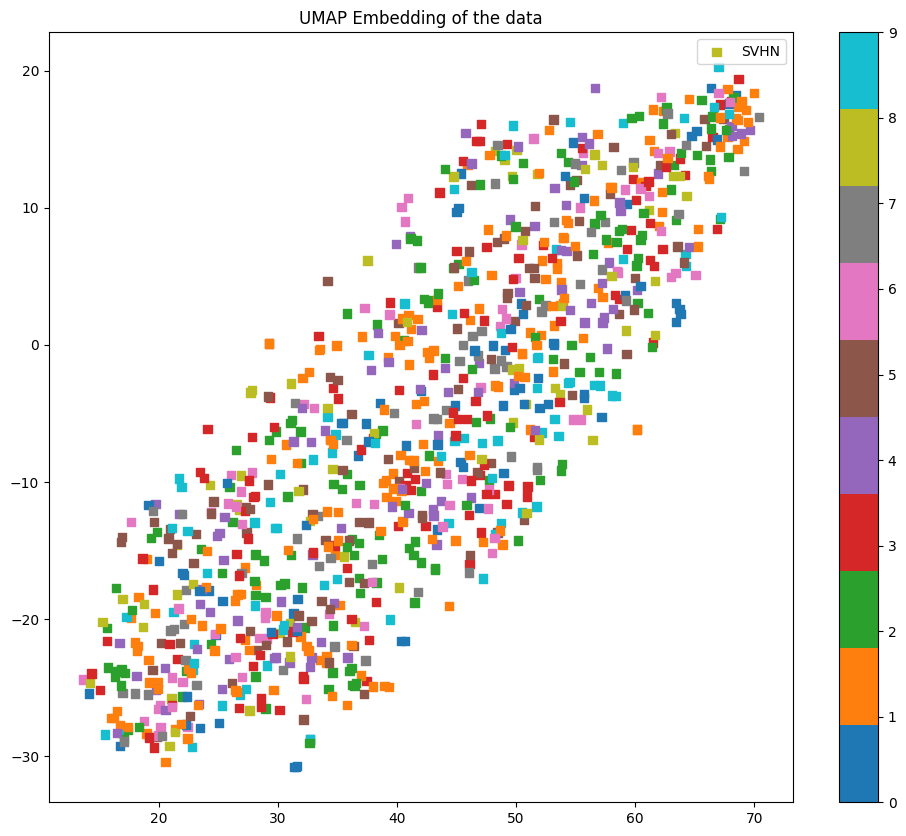

In [37]:
plt.figure(3,(12,10))

plt.scatter(xpSVHN[:,0],xpSVHN[:,1],c=SVHN_ytrain_res,marker='s',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the data')
plt.show()

**Question**: Are the data clearly clustered and well separated as for the other two datasets ? If not, why is that in your opinion ?

Hint: think about the input space of UMAP...

Contrary to the 2 other datasets, data are not well separated and we cannot distinguish clusters. This may be due to the reduction of dimension imposed: from 1024 to 2, or because of the dataset itself (as it works well for USPS and MNIST). Indeed, there seems to be much more diversity in images from SVHN for a same label than USPS and MNIST.

# Unsupervised Domain Adaptation

The three data-sets have the same features $\mathcal{X}$ (all images have size $[32 x 32]$)
 and the same classes (output labels) $\mathcal{Y}$ but they have different marginal $p(X)$ distributions.

In this part, we will assume that we only have labeled data in the source domain $S$ but not int the target domain $T$. By matching the source $p_S(X)$ and target $p_T(X)$ marginal distributions, one can hope that a classifier learnt on $S$ will also work on $T$.

Here, you will implement and test the following algorithm based on subspace alignement:

B. Fernando et al. "*Unsupervised Visual Domain Adaptation Using Subspace Alignment*". ICCV, 2013.

The first thing to do is to choose the source domain and the target domain.
Let's start with the MNIST dataset as source and USPS as target.

We will use the previousyly computed reduced datasets to speed up computations.

In [38]:
# Source domain
XtrainS = MNIST_Xtrain_res
ytrainS = MNIST_ytrain_res
XtestS = MNIST_Xtest
ytestS = MNIST_ytest

# Target domain
XtrainT = USPS_Xtrain_res
ytrainT = USPS_ytrain_res
XtestT = USPS_Xtest
ytestT = USPS_ytest

# Target domain
# XtrainT = SVHN_Xtrain_res
# ytrainT = SVHN_ytrain_res
# XtestT = SVHN_Xtest
# ytestT = SVHN_ytest

Ns=1000 # number of samples in source domain
Nt=1000 # number of samples in target domain

Implement the method following the description of the method in the slides of the lecture (around slide 75).  

In [40]:
from sklearn.decomposition import PCA

def SA(XTrainS,XTestS,XTrainT,XTestT,d=10):
  """
  Subspace Alignment (SA)

  Input
  XTrainS : Input training source data [NTrS,D]
  XTestS : Input test source data [NTeS,D]
  XTrainT : Input training target data [NTrT,D]
  XTestT : Input test target data [NTeT,D]
  d : number of PCA components

  Output
  XTrainSp : projected and transformed source training data [NTrS,d]
  XTestSp : projected and transformed source test data [NTeS,d]
  XTrainTp : projected training target data [NTrT,d]
  XTestTp : projected test target data [NTeT,d]
  """

  pca_s = PCA(n_components=d).fit(XTrainS)
  pca_t = PCA(n_components=d).fit(XTrainT)

  US = pca_s.components_.T
  UT = pca_t.components_.T

  M = np.matmul(US.T, UT)

  transformation_matrix = np.matmul(US, M)
  XTrainSp = np.matmul(XTrainS, transformation_matrix)
  XTestSp = np.matmul(XTestS, transformation_matrix)

  XTrainTp = np.matmul(XTrainT, UT)
  XTestTp = np.matmul(XTestT, UT)

  return XTrainSp,XTestSp,XTrainTp,XTestTp


We start by veryfying the score of a classifier trained on the source domain and tested on the target domain (no adaptation).

You can use the classifier you want (e.g., logistic regression, SVM, ...)

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

logreg = LogisticRegression(max_iter=1000).fit(XtrainS, ytrainS)
predictions = logreg.predict(XtrainT)
accuracy = accuracy_score(ytrainT, predictions)
print(f"Accuracy with Logistic regression: {accuracy}")

svm = SVC(kernel="linear").fit(XtrainS, ytrainS)
predictions = svm.predict(XtrainT)
accuracy = accuracy_score(ytrainT, predictions)
print(f"Accuracy with SVM: {accuracy}")

Accuracy with Logistic regression: 0.581
Accuracy with SVM: 0.607


To reduce dimensionality, we can also first compute PCA using the source training set and then project (i.e., transform) all data (source and target, training and test) on the first $d$ components.

**Question**: try different values of $d$. Is there a difference with the previous full-training data appraoch ?

In [63]:
d_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

print("Results with the Logistic Regression Model:")
print("\n")

for d in d_list:
    pca = PCA(n_components=d)
    pca.fit(XtrainS)

    XtrainS_pca = pca.transform(XtrainS)
    XtrainT_pca = pca.transform(XtrainT)

    logreg = LogisticRegression(max_iter=1000).fit(XtrainS_pca, ytrainS)
    predictions = logreg.predict(XtrainT_pca)

    accuracy = accuracy_score(ytrainT, predictions)
    print(f"Accuracy with {d} components: {accuracy}")

Results with the Logistic Regression Model:


Accuracy with 10 components: 0.552
Accuracy with 20 components: 0.6
Accuracy with 30 components: 0.559
Accuracy with 40 components: 0.568
Accuracy with 50 components: 0.563
Accuracy with 60 components: 0.576
Accuracy with 70 components: 0.581
Accuracy with 80 components: 0.579
Accuracy with 90 components: 0.571
Accuracy with 100 components: 0.573


In [64]:
print("Results with the SVM Model:")
print("\n")

for d in d_list:
    pca = PCA(n_components=d)
    pca.fit(XtrainS)

    XtrainS_pca = pca.transform(XtrainS)
    XtrainT_pca = pca.transform(XtrainT)

    svm = SVC(kernel="linear").fit(XtrainS_pca, ytrainS)
    predictions = svm.predict(XtrainT_pca)

    accuracy = accuracy_score(ytrainT, predictions)
    print(f"Accuracy with {d} components: {accuracy}")

Results with the SVM Model:


Accuracy with 10 components: 0.512
Accuracy with 20 components: 0.591
Accuracy with 30 components: 0.613
Accuracy with 40 components: 0.597
Accuracy with 50 components: 0.593
Accuracy with 60 components: 0.584
Accuracy with 70 components: 0.576
Accuracy with 80 components: 0.586
Accuracy with 90 components: 0.597
Accuracy with 100 components: 0.599


For 20 (resp. 30) components, we observe a slightly better accuracy than the one obtained with the previous full-training data approach for the Logistic Regression (resp. SVM) model. Otherwise, accuracies are very similar.

We can now test the SA approach.

**Question**: try different values of $d$. Does the performance improve on the target domain ? Try at least two different ML methods (one linear and one non-linear) and one DL architecture (it can be a pre-trained model or a simple architecture). What's the best ?

In [61]:
print("Results with the Logistic Regression Model:")
print("\n")

for d in d_list:
    XtrainSp,XtestSp,XtrainTp,XtestTp = SA(XtrainS,XtestS,XtrainT,XtestT,d=d)

    logreg = LogisticRegression(max_iter=1000).fit(XtrainSp, ytrainS)
    predictions = logreg.predict(XtrainTp)

    accuracy = accuracy_score(ytrainT, predictions)
    print(f"Accuracy with {d} components: {accuracy}")

Results with the Logistic Regression Model:


Accuracy with 10 components: 0.466
Accuracy with 20 components: 0.633
Accuracy with 30 components: 0.637
Accuracy with 40 components: 0.688
Accuracy with 50 components: 0.676
Accuracy with 60 components: 0.693
Accuracy with 70 components: 0.702
Accuracy with 80 components: 0.698
Accuracy with 90 components: 0.698
Accuracy with 100 components: 0.692


In [66]:
print("Results with the SVM Model:")
print("\n")

for d in d_list:
    XtrainSp,XtestSp,XtrainTp,XtestTp = SA(XtrainS,XtestS,XtrainT,XtestT,d=d)

    svm = SVC(kernel="linear").fit(XtrainSp, ytrainS)
    predictions = svm.predict(XtrainTp)

    accuracy = accuracy_score(ytrainT, predictions)
    print(f"Accuracy with {d} components: {accuracy}")

Results with the SVM Model:


Accuracy with 10 components: 0.572
Accuracy with 20 components: 0.662
Accuracy with 30 components: 0.695
Accuracy with 40 components: 0.708
Accuracy with 50 components: 0.713
Accuracy with 60 components: 0.721
Accuracy with 70 components: 0.714
Accuracy with 80 components: 0.702
Accuracy with 90 components: 0.696
Accuracy with 100 components: 0.704


In [67]:
from sklearn.neural_network import MLPClassifier

print("Results with the MLP:")
print("\n")

for d in d_list:
    XtrainSp,XtestSp,XtrainTp,XtestTp = SA(XtrainS,XtestS,XtrainT,XtestT,d=d)

    mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000).fit(XtrainSp, ytrainS)
    predictions = mlp.predict(XtrainTp)

    accuracy = accuracy_score(ytrainT, predictions)
    print(f"Accuracy with {d} components: {accuracy}")

Results with the MLP:


Accuracy with 10 components: 0.5
Accuracy with 20 components: 0.681
Accuracy with 30 components: 0.664
Accuracy with 40 components: 0.705
Accuracy with 50 components: 0.701
Accuracy with 60 components: 0.71
Accuracy with 70 components: 0.709
Accuracy with 80 components: 0.693
Accuracy with 90 components: 0.706
Accuracy with 100 components: 0.697


With the SA approach, for the 3 methods, accuracies obtained are far better than the ones obtained before (training on full data and PCA). The best accuracy is reached by the SVM model with 60 components: 0.721.

**Question**: Use the UMAP or t-SNE visualization to check whether the data are more similar after the SA adaptation. What can you conclude ?

(2000, 2)


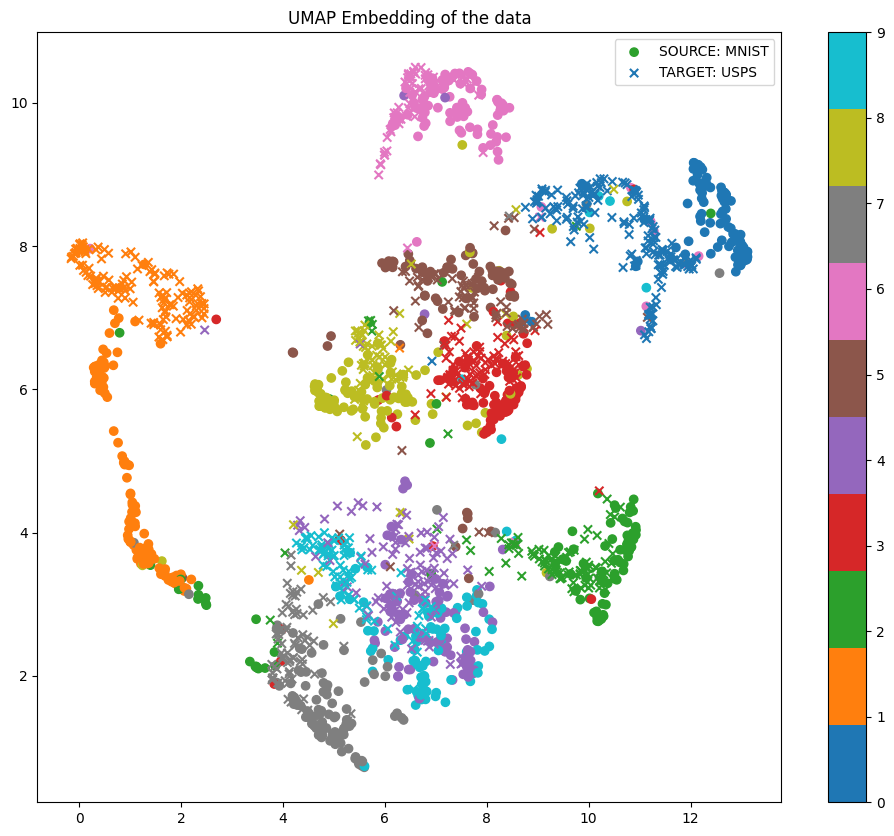

In [69]:
XtrainSp,XtestSp,XtrainTp,XtestTp = SA(XtrainS,XtestS,XtrainT,XtestT,d=60)

xtot=np.concatenate((XtrainSp,XtrainTp),axis=0) # all data
nSOURCE=XtrainSp.shape[0]

xp = UMAP().fit_transform(xtot) # this should take ~50sec

print(xp.shape)

# separate again but now in 2D
xpSOURCE=xp[:nSOURCE,:]
xpTARGET=xp[nSOURCE:,:]

plt.figure(3,(12,10))

plt.scatter(xpSOURCE[:,0],xpSOURCE[:,1],c=ytrainS,marker='o',cmap='tab10',label='SOURCE: MNIST')
plt.scatter(xpTARGET[:,0],xpTARGET[:,1],c=ytrainT,marker='x',cmap='tab10',label='TARGET: USPS')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the data')
plt.show()

After the SA adaptation, the different clusters from each dataset are very close to the corresponding ones, meaning that SA works well. However, it was assumed that there was no domain shift between MNIST and USPS. To validate the method, we should try on SVHN as a target.

**Question**: Repeat the same experiments for different Source and Target domains. Use at least the two followng configurations:

Source: MNIST, Target: USPS

Source MNIST, Target: SVHN

**Queston**: Comment the results.

We now use SVHN as Target.

In [70]:
# Target domain
XtrainT = SVHN_Xtrain_res
ytrainT = SVHN_ytrain_res
XtestT = SVHN_Xtest
ytestT = SVHN_ytest

print("Results with the Logistic Regression Model:")
print("\n")

for d in d_list:
    XtrainSp,XtestSp,XtrainTp,XtestTp = SA(XtrainS,XtestS,XtrainT,XtestT,d=d)

    logreg = LogisticRegression(max_iter=1000).fit(XtrainSp, ytrainS)
    predictions = logreg.predict(XtrainTp)

    accuracy = accuracy_score(ytrainT, predictions)
    print(f"Accuracy with {d} components: {accuracy}")

Results with the Logistic Regression Model:


Accuracy with 10 components: 0.086
Accuracy with 20 components: 0.154
Accuracy with 30 components: 0.101
Accuracy with 40 components: 0.107
Accuracy with 50 components: 0.094
Accuracy with 60 components: 0.119
Accuracy with 70 components: 0.096
Accuracy with 80 components: 0.094
Accuracy with 90 components: 0.093
Accuracy with 100 components: 0.097


In [76]:
print("Results with the SVM Model:")
print("\n")

for d in d_list:
    XtrainSp,XtestSp,XtrainTp,XtestTp = SA(XtrainS,XtestS,XtrainT,XtestT,d=d)

    svm = SVC(kernel="linear").fit(XtrainSp, ytrainS)
    predictions = svm.predict(XtrainTp)

    accuracy = accuracy_score(ytrainT, predictions)
    print(f"Accuracy with {d} components: {accuracy}")

Results with the SVM Model:


Accuracy with 10 components: 0.115
Accuracy with 20 components: 0.145
Accuracy with 30 components: 0.103
Accuracy with 40 components: 0.111
Accuracy with 50 components: 0.092
Accuracy with 60 components: 0.134
Accuracy with 70 components: 0.112
Accuracy with 80 components: 0.119
Accuracy with 90 components: 0.097
Accuracy with 100 components: 0.109


In [72]:
print("Results with the MLP:")
print("\n")

for d in d_list:
    XtrainSp,XtestSp,XtrainTp,XtestTp = SA(XtrainS,XtestS,XtrainT,XtestT,d=d)

    mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000).fit(XtrainSp, ytrainS)
    predictions = mlp.predict(XtrainTp)

    accuracy = accuracy_score(ytrainT, predictions)
    print(f"Accuracy with {d} components: {accuracy}")

Results with the MLP:


Accuracy with 10 components: 0.152
Accuracy with 20 components: 0.163
Accuracy with 30 components: 0.105
Accuracy with 40 components: 0.102
Accuracy with 50 components: 0.106
Accuracy with 60 components: 0.105
Accuracy with 70 components: 0.086
Accuracy with 80 components: 0.1
Accuracy with 90 components: 0.079
Accuracy with 100 components: 0.08


(2000, 2)


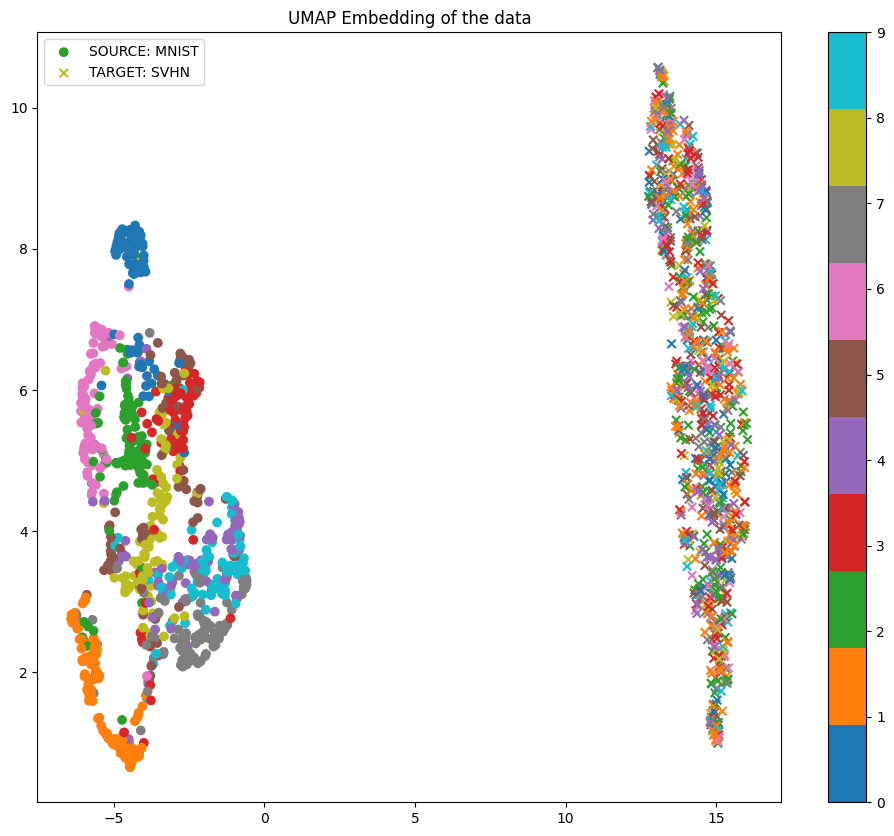

In [79]:
XtrainSp,XtestSp,XtrainTp,XtestTp = SA(XtrainS,XtestS,XtrainT,XtestT,d=20)

xtot=np.concatenate((XtrainSp,XtrainTp),axis=0) # all data
nSOURCE=XtrainSp.shape[0]

xp = UMAP().fit_transform(xtot) # this should take ~50sec

print(xp.shape)

# separate again but now in 2D
xpSOURCE=xp[:nSOURCE,:]
xpTARGET=xp[nSOURCE:,:]

plt.figure(3,(12,10))

plt.scatter(xpSOURCE[:,0],xpSOURCE[:,1],c=ytrainS,marker='o',cmap='tab10',label='SOURCE: MNIST')
plt.scatter(xpTARGET[:,0],xpTARGET[:,1],c=ytrainT,marker='x',cmap='tab10',label='TARGET: SVHN')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the data')
plt.show()

(2000, 2)


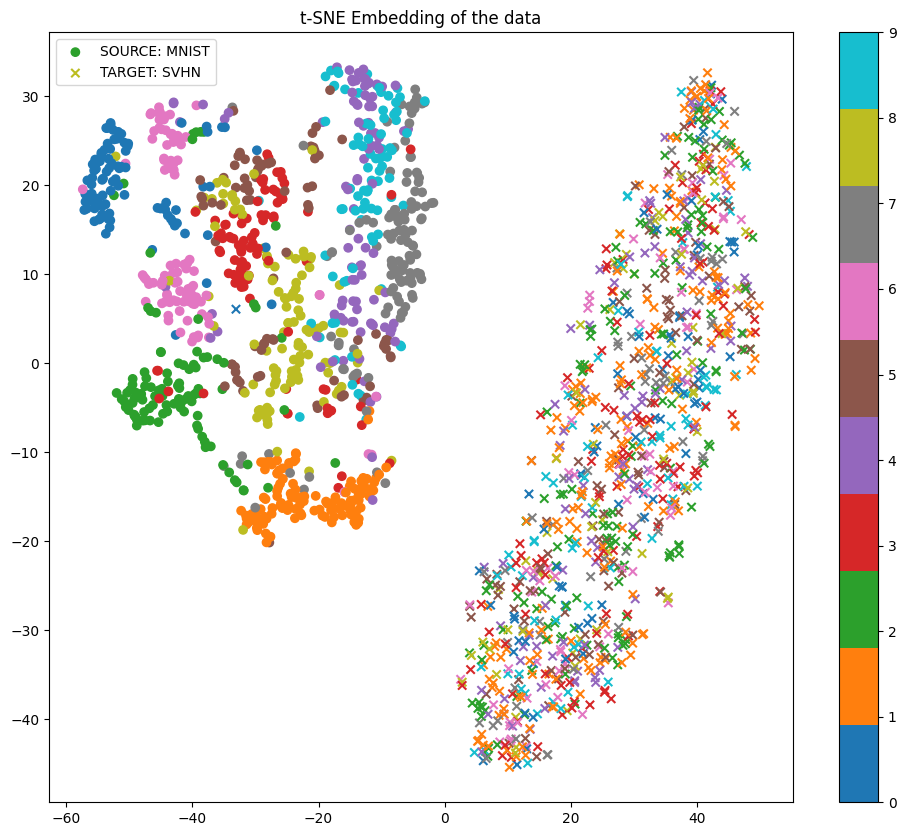

In [80]:
xp=TSNE().fit_transform(xtot)

print(xp.shape)

# separate again but now in 2D
xpSOURCE=xp[:nSOURCE,:]
xpTARGET=xp[nSOURCE:,:]

plt.figure(3,(12,10))

plt.scatter(xpSOURCE[:,0],xpSOURCE[:,1],c=ytrainS,marker='o',cmap='tab10',label='SOURCE: MNIST')
plt.scatter(xpTARGET[:,0],xpTARGET[:,1],c=ytrainT,marker='x',cmap='tab10',label='TARGET: SVHN')
plt.legend()
plt.colorbar()
plt.title('t-SNE Embedding of the data')
plt.show()

Unfortunately, the method does not work really well when comparing MNIST to SVHN. Accuracies are really low, the best one is 0.163 obtained with the MLP and 20 components. UMAP and t-SNE visualisations confirm that there is still a covariate shift between the 2 datasets. An extension could be the DANN method to estimate a domain-invariant representation, or the CyCADA method.

**Question**: What does it happen if you decrease the number of samples for the labeled training set? Is it expected based on the theory seen during the lecture ?

To answer to this question, we will use MNIST as the source dataset, USPS as the target dataset, and SVM as the classifier, after SA with 60 components (best accuracy found in this notebook).

In [87]:
# Target domain
XtrainT = USPS_Xtrain_res
ytrainT = USPS_ytrain_res

n_samples_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

for n_samples in n_samples_list:
    # Source domain
    XtrainS = MNIST_Xtrain_res[:n_samples]
    ytrainS = MNIST_ytrain_res[:n_samples]

    XtrainSp,XtestSp,XtrainTp,XtestTp = SA(XtrainS,XtestS,XtrainT,XtestT,d=60)

    svm = SVC(kernel="linear").fit(XtrainSp, ytrainS)
    predictions = svm.predict(XtrainTp)

    accuracy = accuracy_score(ytrainT, predictions)
    print(f"Accuracy with {n_samples} samples: {accuracy}")

Accuracy with 100 samples: 0.511
Accuracy with 200 samples: 0.587
Accuracy with 300 samples: 0.591
Accuracy with 400 samples: 0.605
Accuracy with 500 samples: 0.66
Accuracy with 600 samples: 0.654
Accuracy with 700 samples: 0.706
Accuracy with 800 samples: 0.701
Accuracy with 900 samples: 0.682
Accuracy with 1000 samples: 0.721


If we decrease the number of samples for the labeled training set ($n$), accuracies of the method decrease too. Based on the theory, it is expected as the complexity of the model family $\mathcal{F}$ decreases with $n$, and that is why we should use a large training dataset.